<a href="https://colab.research.google.com/github/AfroGrit/jenga-stock/blob/wk2/Module02_working_with_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install main library YFinance
# !pip install yfinance

### 0. imports

In [3]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt


## 1.0 IPOs data from Web
* "stacking" (UNION ALL)
* type casting
* generate new columns (simple and with function)

In [4]:

import pandas as pd
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
}

url = "https://stockanalysis.com/ipos/2023/"
response = requests.get(url, headers=headers)
ipo_dfs = pd.read_html(response.text)

ipos_2023 = ipo_dfs[0]
ipos_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [5]:

url = "https://stockanalysis.com/ipos/2024/"
response = requests.get(url, headers=headers)
ipo_dfs = pd.read_html(response.text)

ipos_2024 = ipo_dfs[0]
ipos_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      65 non-null     object
 1   Symbol        65 non-null     object
 2   Company Name  65 non-null     object
 3   IPO Price     65 non-null     object
 4   Current       65 non-null     object
 5   Return        65 non-null     object
dtypes: object(6)
memory usage: 3.2+ KB


In [6]:

# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2024, ipos_2023], ignore_index=True)
stacked_ipos_df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"May 8, 2024",NNE,Nano Nuclear Energy Inc.,$4.00,$5.19,29.75%
1,"May 1, 2024",VIK,Viking Holdings Ltd.,$24.00,$28.50,18.75%
2,"Apr 26, 2024",ZONE,"CleanCore Solutions, Inc.",$4.00,$3.17,-20.75%
3,"Apr 25, 2024",RBRK,"Rubrik, Inc.",$32.00,$33.57,4.91%
4,"Apr 25, 2024",LOAR,Loar Holdings Inc.,$28.00,$48.68,73.86%


In [7]:
# Check the dtypes
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      219 non-null    object
 1   Symbol        219 non-null    object
 2   Company Name  219 non-null    object
 3   IPO Price     219 non-null    object
 4   Current       219 non-null    object
 5   Return        219 non-null    object
dtypes: object(6)
memory usage: 10.4+ KB


In [8]:
# convert to datetime

# stacked_ipos_df["IPO Date"] = pd.to_datetime(stacked_ipos_df["IPO Date"], format='mixed')
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='%b %d, %Y')

In [9]:
# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df


,IPO Date,Symbol,Company Name,IPO Price,Current,Return


In [10]:

# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])

In [11]:
# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100

In [12]:
# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      219 non-null    datetime64[ns]
 1   Symbol        219 non-null    object        
 2   Company Name  219 non-null    object        
 3   IPO Price     219 non-null    float64       
 4   Current       219 non-null    float64       
 5   Return        217 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.4+ KB


In [13]:

# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()

IPO Date        0
Symbol          0
Company Name    0
IPO Price       0
Current         0
Return          2
dtype: int64

In [14]:

# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
5,2024-04-25,MRX,Marex Group plc,19.00,19.00,NaN
197,2023-02-15,GXAI,Gaxos.ai Inc.,4.15,4.15,NaN


In [15]:
# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()


11.02799086757991

In [16]:

# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
stacked_ipos_df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2024-05-08,NNE,Nano Nuclear Energy Inc.,4.0,5.19,0.2975,1.19
1,2024-05-01,VIK,Viking Holdings Ltd.,24.0,28.50,0.1875,4.50
2,2024-04-26,ZONE,"CleanCore Solutions, Inc.",4.0,3.17,-0.2075,-0.83
3,2024-04-25,RBRK,"Rubrik, Inc.",32.0,33.57,0.0491,1.57
4,2024-04-25,LOAR,Loar Holdings Inc.,28.0,48.68,0.7386,20.68


In [17]:

# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,219,219.000000,219.000000,217.000000,219.000000
mean,2023-09-09 06:21:22.191780864,11.027991,11.113607,-0.197865,0.085616
min,2023-01-13 00:00:00,2.500000,0.000000,-0.999600,-20.440000
25%,2023-04-20 00:00:00,4.000000,1.255000,-0.724000,-3.645000
50%,2023-09-15 00:00:00,8.000000,5.730000,-0.242500,-1.550000
75%,2024-01-25 00:00:00,13.500000,10.860000,0.059000,0.630000
max,2024-05-08 00:00:00,92.000000,118.270000,2.672500,55.070000
std,NaN,11.229966,16.985739,0.652283,8.977968


In [18]:

# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()


In [19]:


# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
reddit = yf.download(tickers = "RDDT",
                     period = "max",
                     interval = "1d")

reddit.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,46.610001,49.639000,45.720001,47.700001,47.700001,2365000
2024-05-03,48.439999,48.700001,46.240002,46.639999,46.639999,1188300
2024-05-06,46.990002,49.869999,46.750000,48.270000,48.270000,2116700
2024-05-07,47.730000,50.330002,47.400002,49.400002,49.400002,6241700
2024-05-08,55.000000,55.160000,49.700001,51.400002,51.400002,13491500


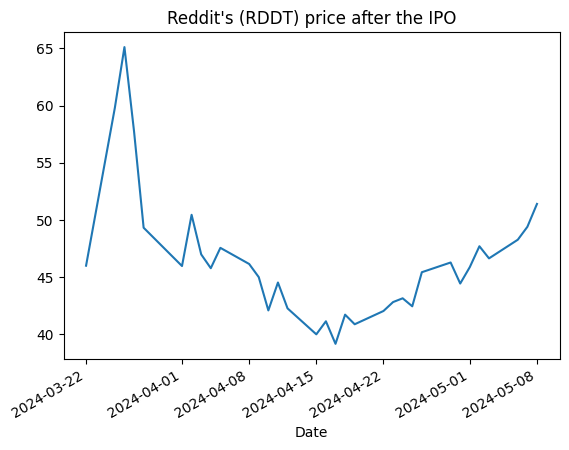

In [20]:
reddit['Adj Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO');


## 2.1 Time series for OHLCV

In [21]:
nvo_df = yf.download(tickers = "NVO", period = "max", interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [22]:
# NB: DatetimeIndex - it is a recognised date
nvo_df.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10847 entries, 1981-04-30 to 2024-05-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10847 non-null  float64
 1   High       10847 non-null  float64
 2   Low        10847 non-null  float64
 3   Close      10847 non-null  float64
 4   Adj Close  10847 non-null  float64
 5   Volume     10847 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 593.2 KB


In [23]:
nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100
2024-05-03,122.919998,123.769997,121.290001,123.050003,123.050003,5932900
2024-05-06,122.000000,124.639999,121.779999,124.589996,124.589996,3636600
2024-05-07,126.650002,127.800003,126.379997,127.290001,127.290001,4167500
2024-05-08,127.510002,128.429993,126.620003,126.690002,126.690002,4059000


(<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>,)

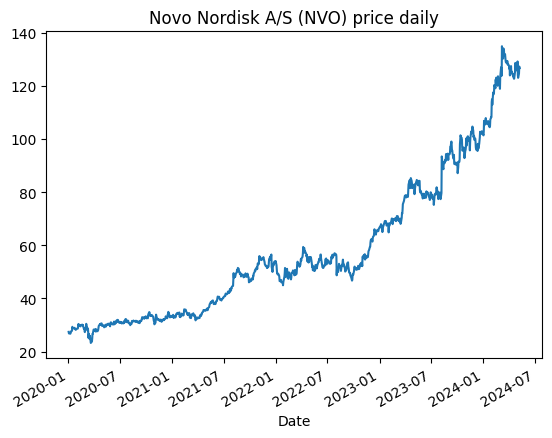

In [24]:
# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']

# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Adj Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily'),
# nvo_df_filtered_from_2024['Adj Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily');

In [25]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02
2024-05-03,122.919998,123.769997,121.290001,123.050003,123.050003,5932900,NVO,2024,5,4,2024-05-03
2024-05-06,122.000000,124.639999,121.779999,124.589996,124.589996,3636600,NVO,2024,5,0,2024-05-06
2024-05-07,126.650002,127.800003,126.379997,127.290001,127.290001,4167500,NVO,2024,5,1,2024-05-07
2024-05-08,127.510002,128.429993,126.620003,126.690002,126.690002,4059000,NVO,2024,5,2,2024-05-08


In [26]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['adj_close_minus_1'] = nvo_df['Adj Close'].shift(-1)
nvo_df['adj_close_plus_1'] = nvo_df['Adj Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,Date,adj_close_minus_1,adj_close_plus_1
Date,,,,,,,,,,,,,
2024-05-02,127.940002,127.940002,123.830002,124.019997,124.019997,8487100,NVO,2024,5,3,2024-05-02,123.050003,129.210007
2024-05-03,122.919998,123.769997,121.290001,123.050003,123.050003,5932900,NVO,2024,5,4,2024-05-03,124.589996,124.019997
2024-05-06,122.000000,124.639999,121.779999,124.589996,124.589996,3636600,NVO,2024,5,0,2024-05-06,127.290001,123.050003
2024-05-07,126.650002,127.800003,126.379997,127.290001,127.290001,4167500,NVO,2024,5,1,2024-05-07,126.690002,124.589996
2024-05-08,127.510002,128.429993,126.620003,126.690002,126.690002,4059000,NVO,2024,5,2,2024-05-08,NaN,127.290001


In [27]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(1)           # nvo_df['adj_close_plus_1']
nvo_df['growth_30d'] = nvo_df['Adj Close'] / nvo_df['Adj Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Adj Close'].shift(-1) / nvo_df['Adj Close']   # nvo_df['adj_close_minus_1']

# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)

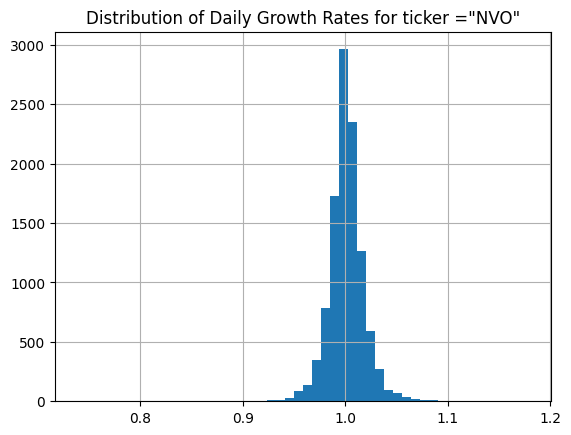

In [28]:
# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.title('Distribution of Daily Growth Rates for ticker ="NVO"')
nvo_df.growth_1d.hist(bins=50)
plt.show()

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

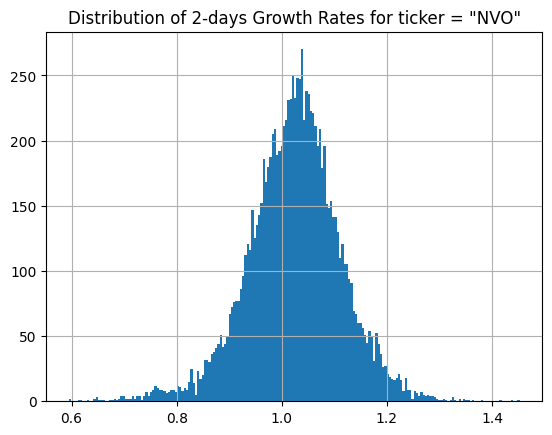

In [29]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [30]:
# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Adj Close']
nvo_df[COLUMNS].tail()

,Adj Close,growth_1d,growth_30d,growth_future_1d,is_positive_growth_1d_future
Date,,,,,
2024-05-02,124.019997,0.959833,0.958229,0.992179,0
2024-05-03,123.050003,0.992179,0.954616,1.012515,1
2024-05-06,124.589996,1.012515,0.967614,1.021671,1
2024-05-07,127.290001,1.021671,0.986362,0.995286,0
2024-05-08,126.690002,0.995286,0.978982,NaN,0


In [31]:
# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)

is_positive_growth_1d_future
0    0.512861
1    0.487139
Name: count, dtype: float64

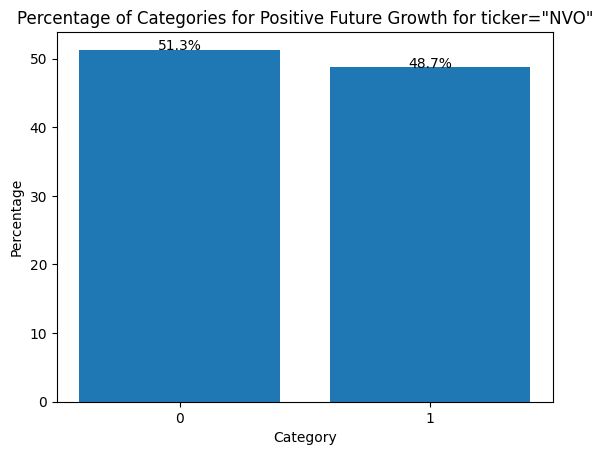

In [32]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_1d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

## 2.2 Candlestick chart for OHLCV

In [33]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

## 3. Macro Indicators

In [34]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2024; month= 5; day=9
Period for indexes: 1954-05-09 to 2024-05-09 


In [35]:
# reuse code for ealier covered indicators
dax_daily = yf.download(tickers = "^GDAXI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [36]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Adj Close'] / dax_daily['Adj Close'].shift(i)

In [37]:
dax_daily.head()
# dax_daily.tail()

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
1987-12-30,1005.190002,1005.190002,1005.190002,1005.190002,1005.190002,0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04,956.489990,956.489990,956.489990,956.489990,956.489990,0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05,996.099976,996.099976,996.099976,996.099976,996.099976,0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06,1006.010010,1006.010010,1006.010010,1006.010010,1006.010010,0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07,1014.469971,1014.469971,1014.469971,1014.469971,1014.469971,0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [38]:
dax_daily.tail()

,Open,High,Low,Close,Adj Close,Volume,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,
2024-05-03,17900.150391,18105.820312,17900.019531,18001.599609,18001.599609,71259900,1.005873,0.993558,0.992499,1.000784,1.078753,1.237957
2024-05-06,18001.130859,18199.150391,18001.130859,18175.210938,18175.210938,46036600,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628
2024-05-07,18175.210938,18442.400391,18175.210938,18430.050781,18430.050781,85365200,1.014021,1.029813,1.028619,1.013796,1.100823,1.283836
2024-05-08,18430.250000,18542.099609,18427.259766,18498.380859,18498.380859,74222500,1.003708,1.027597,1.018577,1.016063,1.107585,1.284874
2024-05-09,18498.089844,18564.320312,18488.039062,18543.449219,18543.449219,0,1.002436,1.020260,1.023464,1.015450,1.106963,1.279715


In [39]:
GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail()

,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2024-05-03,1.005873,0.993558,0.992499,1.000784,1.078753,1.237957
2024-05-06,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628
2024-05-07,1.014021,1.029813,1.028619,1.013796,1.100823,1.283836
2024-05-08,1.003708,1.027597,1.018577,1.016063,1.107585,1.284874
2024-05-09,1.002436,1.020260,1.023464,1.015450,1.106963,1.279715


In [40]:
def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Adj Close'] / df['Adj Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]

In [41]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
snp500_daily = yf.download(tickers = "^GSPC",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [42]:
snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail()

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2024-05-02,1.009128,0.989842,0.998748,0.969295,1.066877,1.279229
2024-05-03,1.012557,1.018289,1.011073,0.978300,1.078484,1.299306
2024-05-06,1.010326,1.032351,1.026210,0.989790,1.085029,1.306506
2024-05-07,1.001343,1.024387,1.017204,0.994157,1.084934,1.313362
2024-05-08,0.999994,1.011678,1.013975,0.996942,1.084526,1.295758


In [43]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch
dji_daily = yf.download(tickers = "^DJI",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [44]:
dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail()

,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2024-05-02,1.008505,0.995821,0.992779,0.967441,1.021958,1.139234
2024-05-03,1.011773,1.022735,1.005584,0.972206,1.034497,1.152904
2024-05-06,1.004566,1.025037,1.020125,0.984202,1.034810,1.151325
2024-05-07,1.000823,1.017229,1.016857,0.989078,1.032604,1.153826
2024-05-08,1.004427,1.009844,1.017462,0.994248,1.035701,1.145412


In [46]:
# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI
epi_etf_daily = yf.download(tickers = "EPI",
                     period = "max",
                     interval = "1d")
epi_etf_daily.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-02,45.549999,45.750000,45.450001,45.700001,45.700001,1492000
2024-05-03,45.480000,45.560001,45.410000,45.560001,45.560001,1121100
2024-05-06,45.099998,45.110001,44.919998,45.020000,45.020000,1533600
2024-05-07,44.400002,44.459999,44.299999,44.419998,44.419998,1080700
2024-05-08,44.459999,44.660000,44.450001,44.549999,44.549999,1440300


In [48]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail()

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2024-05-02,1.010168,1.005501,1.024204,1.073022,1.131188,1.393630
2024-05-03,0.996937,1.008857,1.019239,1.066230,1.122997,1.390207
2024-05-06,0.988147,0.995137,0.999112,1.055321,1.105871,1.374986
2024-05-07,0.986673,0.971991,0.982309,1.039794,1.084208,1.365403
2024-05-08,1.002927,0.977831,0.980198,1.038704,1.079738,1.359388


In [49]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail()

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2023-04-01,22246.23,0.021312,0.005442
2023-07-01,22369.71,0.021719,0.005551
2023-10-01,22495.19,0.022190,0.005609
2024-01-01,22618.15,0.022251,0.005466
2024-04-01,22739.00,0.022151,0.005343


In [50]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail()

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2023-04-01,0.021312,0.005442
2023-07-01,0.021719,0.005551
2023-10-01,0.022190,0.005609
2024-01-01,0.022251,0.005466
2024-04-01,0.022151,0.005343


In [51]:
# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail()

,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2023-11-01,312.349,0.040151,0.003080
2023-12-01,313.209,0.039101,0.002753
2024-01-01,314.438,0.038747,0.003924
2024-02-01,315.565,0.037620,0.003584
2024-03-01,316.698,0.037973,0.003590


In [52]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail()

,cpi_core_yoy,cpi_core_mom
DATE,,
2023-11-01,0.040151,0.003080
2023-12-01,0.039101,0.002753
2024-01-01,0.038747,0.003924
2024-02-01,0.037620,0.003584
2024-03-01,0.037973,0.003590


In [53]:
# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail()

,FEDFUNDS
DATE,
2023-12-01,5.33
2024-01-01,5.33
2024-02-01,5.33
2024-03-01,5.33
2024-04-01,5.33


In [56]:
# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail()

,DGS1
DATE,
2024-05-01,5.21
2024-05-02,5.16
2024-05-03,5.12
2024-05-06,5.12
2024-05-07,5.13


In [58]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail()

,DGS5
DATE,
2024-05-01,4.64
2024-05-02,4.57
2024-05-03,4.48
2024-05-06,4.48
2024-05-07,4.48


In [59]:
# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail()

,DGS10
DATE,
2024-05-01,4.63
2024-05-02,4.58
2024-05-03,4.50
2024-05-06,4.49
2024-05-07,4.47


## 3.1 VIX - Volatility Index

The CBOE Volatility Index (VIX), also known as the VIX, is a real-time market index that represents the market’s expectations for volatility over the coming 30 days. Here are the key points about the VIX


The VIX is a real-time market index that reflects market expectations for **volatility** over the next 30 days. It is often referred to as the **"fear index"** and provides insight into investor sentiment and risk perception. Traders and investors use the VIX to assess market conditions and anticipate potential price fluctuations. 🌟



In [60]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/
vix = yf.download(tickers = "^VIX",
                     period = "max",
                     interval = "1d")

[*********************100%%**********************]  1 of 1 completed


In [61]:
vix.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,14.51,14.58,13.48,13.49,13.49,0
2024-05-06,13.98,14.02,13.44,13.49,13.49,0
2024-05-07,13.52,13.64,13.16,13.23,13.23,0
2024-05-08,13.24,13.51,12.94,13.00,13.00,0
2024-05-09,13.08,13.29,13.07,13.24,13.24,0


In [62]:
vix_to_merge = vix['Adj Close']
vix_to_merge.tail()

Date
2024-05-03    13.49
2024-05-06    13.49
2024-05-07    13.23
2024-05-08    13.00
2024-05-09    13.24
Name: Adj Close, dtype: float64

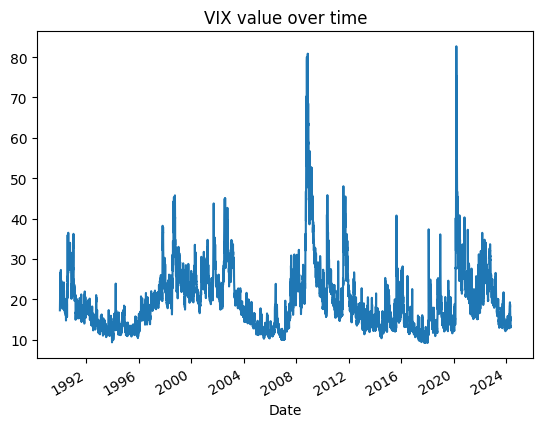

In [64]:
# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Adj Close'].plot.line(title = "VIX value over time");

In [65]:
# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Adj Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.2 other assets - Gold

In [66]:
# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF
gold = yf.download(tickers = "GC=F",
                     period = "max",
                     interval = "1d")

gold.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,2300.000000,2301.000000,2277.600098,2299.000000,2299.000000,194
2024-05-06,2322.800049,2325.500000,2314.199951,2321.600098,2321.600098,9
2024-05-07,2324.300049,2324.300049,2315.199951,2315.199951,2315.199951,25
2024-05-08,2313.600098,2313.600098,2313.600098,2313.600098,2313.600098,25
2024-05-09,2316.500000,2326.500000,2312.899902,2322.199951,2322.199951,58980


In [67]:
gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail()

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2024-05-03,0.999913,1.003317,0.989030,1.053427,1.117593,1.312289
2024-05-06,1.009830,1.009435,0.996480,1.075761,1.127976,1.336250
2024-05-07,0.997243,1.006959,0.991605,1.064558,1.112061,1.331876
2024-05-08,0.999309,1.006351,0.986442,1.063431,1.115579,1.325921
2024-05-09,1.003717,1.000258,1.013442,1.060075,1.125970,1.324474


In [68]:
# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Adj Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

## 3.3 WTI Crude and Brent Oil

In [70]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/
crude_oil = yf.download(tickers = "CL=F",
                     period = "max",
                     interval = "1d")

crude_oil.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,79.070000,79.629997,77.959999,78.110001,78.110001,324438
2024-05-06,78.160004,79.089996,77.910004,78.480003,78.480003,297369
2024-05-07,78.720001,79.169998,77.550003,78.379997,78.379997,327593
2024-05-08,78.339996,79.269997,76.889999,78.989998,78.989998,327593
2024-05-09,79.230003,79.800003,79.129997,79.540001,79.540001,62124


In [71]:
crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail()

,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2024-05-03,0.989360,0.953375,0.943244,0.963488,1.061854,0.975400
2024-05-06,1.004737,0.993418,0.939093,0.973335,1.038507,0.984322
2024-05-07,0.998726,0.992780,0.934764,0.956437,1.057617,0.968252
2024-05-08,1.007783,1.011266,0.955948,0.967777,1.100599,1.013472
2024-05-09,1.006963,1.013507,0.970829,0.977750,1.110119,1.042737


In [72]:
# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Adj Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()

In [73]:
# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/
brent_oil = yf.download(tickers = "BZ=F",
                     period = "max",
                     interval = "1d")

brent_oil.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-03,83.800003,84.400002,82.800003,82.959999,82.959999,31511
2024-05-06,82.980003,83.820000,82.760002,83.330002,83.330002,23246
2024-05-07,83.589996,83.870003,82.400002,83.160004,83.160004,33414
2024-05-08,83.040001,83.820000,81.720001,83.580002,83.580002,33414
2024-05-09,83.779999,84.330002,83.660004,84.120003,84.120003,6255


In [74]:
brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail()

,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2024-05-03,0.991514,0.944229,0.942513,0.967125,1.049197,0.946816
2024-05-06,1.004460,0.998682,0.936187,0.975418,1.027877,0.952887
2024-05-07,0.997960,0.993905,0.929162,0.958617,1.044068,0.941150
2024-05-08,1.005050,1.007474,0.945475,0.969043,1.066207,0.978574
2024-05-09,1.006461,1.009480,0.957432,0.977117,1.091900,1.005859


In [75]:
# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Adj Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.4 Crypto: BTC_USD

In [76]:
# https://finance.yahoo.com/quote/BTC-USD/
btc_usd =  yf.download(tickers = "BTC-USD",
                     period = "max",
                     interval = "1d")

btc_usd.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-05-08,62332.640625,62986.085938,60877.128906,61187.941406,61187.941406,26088172222
2024-05-09,61171.207031,61739.335938,60719.507812,61128.953125,61128.953125,24669394944


In [77]:
btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail()

,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2024-05-05,1.002186,1.083008,1.014544,0.943888,1.501011,2.215256
2024-05-06,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715
2024-05-07,0.986905,0.975636,1.028002,0.898681,1.406528,2.250820
2024-05-08,0.981601,0.955597,1.050364,0.854206,1.350680,2.212243
2024-05-09,0.999036,0.967813,1.033921,0.884146,1.296555,2.213073


In [78]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Adj Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


## 3.5 Eurostat: "high-quality statistics and data on Europe"


In [80]:
!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database

In [81]:
import eurostat

In [82]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2023-04-01', 'endPeriod':'2024-05-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [83]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Columns: 541 entries, freq to 2024-04-29_flag
dtypes: float64(268), object(273)
memory usage: 8.9+ MB


In [85]:
eurostat_euro_yield_df.tail()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2023-04-03_value,2023-04-03_flag,2023-04-04_value,2023-04-04_flag,2023-04-05_value,...,2024-04-23_value,2024-04-23_flag,2024-04-24_value,2024-04-24_flag,2024-04-25_value,2024-04-25_flag,2024-04-26_value,2024-04-26_flag,2024-04-29_value,2024-04-29_flag
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.38034,,2.40789,,2.29510,...,2.54635,,2.62834,,2.68168,,2.60908,,2.57881,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.09875,,3.13135,,3.03337,...,3.07345,,3.16620,,3.23291,,3.14712,,3.10632,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.38170,,2.40936,,2.29671,...,2.54935,,2.63147,,2.68473,,2.61196,,2.58177,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.10313,,3.13583,,3.03872,...,3.07734,,3.17017,,3.23687,,3.15093,,3.11021,
2147,D,SPOT_RT,Y9_M9,CGB_EA_AAA,EA,2.38305,,2.41082,,2.29830,...,2.55236,,2.63460,,2.68777,,2.61483,,2.58473,


In [86]:
eurostat_euro_yield_df['bonds'].value_counts()

bonds
CGB_EA        1074
CGB_EA_AAA    1074
Name: count, dtype: int64

In [87]:
eurostat_euro_yield_df['maturity'].value_counts()


maturity
M10       6
Y26_M8    6
Y28_M4    6
Y28_M3    6
Y28_M2    6
         ..
Y18_M9    6
Y18_M8    6
Y18_M7    6
Y18_M6    6
Y9_M9     6
Name: count, Length: 358, dtype: int64

In [88]:
eurostat_euro_yield_df['yld_curv'].value_counts()

yld_curv
INS_FWD    716
PAR        716
SPOT_RT    716
Name: count, dtype: int64

In [89]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2023-04-03_value,2023-04-03_flag,2023-04-04_value,2023-04-04_flag,2023-04-05_value,...,2024-04-23_value,2024-04-23_flag,2024-04-24_value,2024-04-24_flag,2024-04-25_value,2024-04-25_flag,2024-04-26_value,2024-04-26_flag,2024-04-29_value,2024-04-29_flag
0,D,INS_FWD,M10,CGB_EA,EA,2.81565,,2.82931,,2.72308,...,3.02264,,3.08430,,3.13182,,3.08867,,3.06128,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,2.78808,,2.79167,,2.60202,...,2.91176,,2.96612,,3.01979,,2.98661,,2.95786,
2,D,INS_FWD,M11,CGB_EA,EA,2.80574,,2.81995,,2.70492,...,2.96704,,3.03342,,3.08275,,3.03647,,3.00758,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,2.74062,,2.74392,,2.54991,...,2.84353,,2.90169,,2.95777,,2.92274,,2.89261,
4,D,INS_FWD,M3,CGB_EA,EA,2.91701,,2.92681,,2.90199,...,3.59855,,3.61313,,3.64745,,3.63097,,3.61332,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.38034,,2.40789,,2.29510,...,2.54635,,2.62834,,2.68168,,2.60908,,2.57881,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.09875,,3.13135,,3.03337,...,3.07345,,3.16620,,3.23291,,3.14712,,3.10632,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.38170,,2.40936,,2.29671,...,2.54935,,2.63147,,2.68473,,2.61196,,2.58177,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.10313,,3.13583,,3.03872,...,3.07734,,3.17017,,3.23687,,3.15093,,3.11021,


In [90]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2024-04-18_value']].head(20)

,maturity,2024-04-18_value
1433,M10,3.36335
1435,M11,3.31940
1437,M3,3.72264
1439,M4,3.66536
1441,M5,3.61017
1443,M6,3.55700
1445,M7,3.50580
1447,M8,3.45649
1449,M9,3.40903
1451,Y1,3.27711


In [91]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [92]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df['maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))

<ipython-input-92-ffa8baf09650>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [93]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2024-04-18_value']].head(20)

,maturity,maturity_in_months,2024-04-18_value
1437,M3,3,3.72264
1439,M4,4,3.66536
1441,M5,5,3.61017
1443,M6,6,3.55700
1445,M7,7,3.50580
1447,M8,8,3.45649
1449,M9,9,3.40903
1433,M10,10,3.36335
1435,M11,11,3.31940
1451,Y1,12,3.27711


In [94]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

<ipython-input-94-c3c6c300f9f8>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



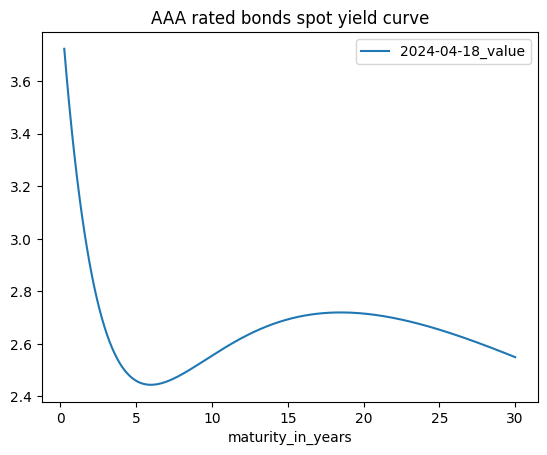

In [96]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2024-04-18_value']] \
  .plot.line(x='maturity_in_years',
            y='2024-04-18_value',
            title='AAA rated bonds spot yield curve');

#£ 4.0 Fundamental indicators

* Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
* https://algotrading101.com/learn/yahoo-finance-api-guide/

In [97]:
# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)

In [98]:
# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings

,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2025-06-05 11:00:00-04:00,0.49,NaN,NaN,WMT
2025-02-20 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-11-19 08:00:00-05:00,NaN,NaN,NaN,WMT
2024-08-15 08:00:00-04:00,NaN,NaN,NaN,WMT
2024-06-05 11:00:00-04:00,0.52,NaN,NaN,WMT
2024-05-16 08:00:00-04:00,0.52,NaN,NaN,WMT
2024-04-10 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-04-03 06:00:00-04:00,0.55,0.6,0.0909,WMT
2024-03-28 06:00:00-04:00,0.55,0.6,0.0909,WMT


In [99]:
one_company.calendar

{'Dividend Date': datetime.date(2025, 1, 6),
 'Ex-Dividend Date': datetime.date(2024, 5, 9),
 'Earnings Date': [datetime.date(2024, 5, 16)],
 'Earnings High': 0.55,
 'Earnings Low': 0.51,
 'Earnings Average': 0.52,
 'Revenue High': 160932000000,
 'Revenue Low': 157591000000,
 'Revenue Average': 159409000000}

In [100]:
one_company.financials

,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,-612140000.0,0.0
Tax Rate For Calcs,0.255,0.336,0.254,0.333
Normalized EBITDA,36384000000.0,30089000000.0,33758000000.0,34031000000.0
Total Unusual Items,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,15511000000.0,11680000000.0,13673000000.0,13510000000.0
Reconciled Depreciation,11853000000.0,10945000000.0,10658000000.0,11152000000.0
Reconciled Cost Of Revenue,490142000000.0,463721000000.0,429000000000.0,420315000000.0
EBITDA,36384000000.0,30089000000.0,31348000000.0,34031000000.0
EBIT,24531000000.0,19144000000.0,20690000000.0,22879000000.0


In [101]:
EPS = one_company.financials.loc['Basic EPS']
EPS

2024-01-31    1.92
2023-01-31    1.43
2022-01-31    1.63
2021-01-31    1.59
Name: Basic EPS, dtype: object

In [104]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']
EBITDA_margin

2024-01-31    0.056137
2023-01-31    0.049222
2022-01-31    0.054732
2021-01-31    0.060862
dtype: object

In [105]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']
NET_INCOME

2024-01-31    15511000000.0
2023-01-31    11680000000.0
2022-01-31    13673000000.0
2021-01-31    13510000000.0
Name: Net Income, dtype: object

In [106]:
# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})

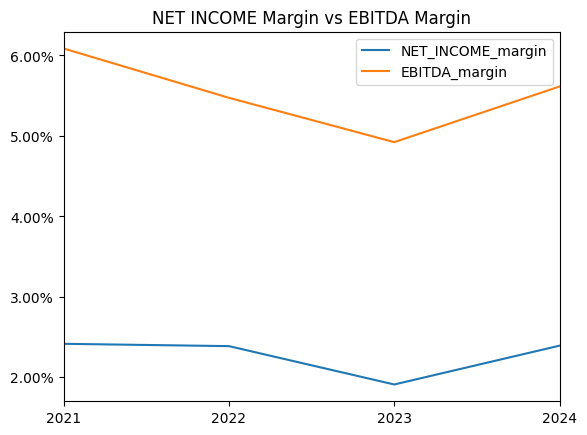

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

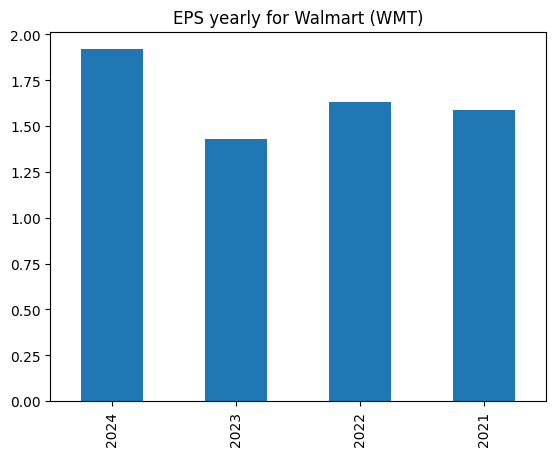

In [108]:
EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()

# 5.0 Daily OHCLV data for a set of stocks

In [109]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']

In [110]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [111]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  historyPrices = yf.download(tickers = ticker,
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Adj Close'] / historyPrices['Adj Close'].shift(i)
  historyPrices['growth_future_5d'] = historyPrices['Adj Close'].shift(-5) / historyPrices['Adj Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Adj Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Adj Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_5d_future'] = np.where(historyPrices['growth_future_5d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT


[*********************100%%**********************]  1 of 1 completed


1 AAPL


[*********************100%%**********************]  1 of 1 completed


2 GOOG


[*********************100%%**********************]  1 of 1 completed


3 NVDA


[*********************100%%**********************]  1 of 1 completed


4 AMZN


[*********************100%%**********************]  1 of 1 completed


5 META


[*********************100%%**********************]  1 of 1 completed


6 BRK-B


[*********************100%%**********************]  1 of 1 completed


7 LLY


[*********************100%%**********************]  1 of 1 completed


8 AVGO


[*********************100%%**********************]  1 of 1 completed


9 V


[*********************100%%**********************]  1 of 1 completed


10 JPM


[*********************100%%**********************]  1 of 1 completed


11 NVO


[*********************100%%**********************]  1 of 1 completed


12 MC.PA


[*********************100%%**********************]  1 of 1 completed


13 ASML


[*********************100%%**********************]  1 of 1 completed


14 RMS.PA


[*********************100%%**********************]  1 of 1 completed


15 OR.PA


[*********************100%%**********************]  1 of 1 completed


16 SAP


[*********************100%%**********************]  1 of 1 completed


17 ACN


[*********************100%%**********************]  1 of 1 completed


18 TTE


[*********************100%%**********************]  1 of 1 completed


19 SIE.DE


[*********************100%%**********************]  1 of 1 completed


20 IDEXY


[*********************100%%**********************]  1 of 1 completed


21 CDI.PA


[*********************100%%**********************]  1 of 1 completed


22 RELIANCE.NS


[*********************100%%**********************]  1 of 1 completed


23 TCS.NS


[*********************100%%**********************]  1 of 1 completed


24 HDB


[*********************100%%**********************]  1 of 1 completed


25 BHARTIARTL.NS


[*********************100%%**********************]  1 of 1 completed


26 IBN


[*********************100%%**********************]  1 of 1 completed


27 SBIN.NS


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

28 LICI.NS


29 INFY


[*********************100%%**********************]  1 of 1 completed


30 ITC.NS


[*********************100%%**********************]  1 of 1 completed


31 HINDUNILVR.NS


[*********************100%%**********************]  1 of 1 completed


32 LT.NS


[*********************100%%**********************]  1 of 1 completed


In [112]:
def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  """
    Determines the type of stock market based on the given ticker symbol.

    Args:
        ticker (str): The stock ticker symbol to check.
        us_stocks_list (list): List of US stock ticker symbols.
        eu_stocks_list (list): List of European stock ticker symbols.
        india_stocks_list (list): List of Indian stock ticker symbols.

    Returns:
        str: The type of stock market ('US', 'EU', 'INDIA', or 'ERROR').

    Example:
        >>> us_stocks = ['AAPL', 'MSFT', 'GOOGL']
        >>> eu_stocks = ['BMW', 'NESN', 'VOW3']
        >>> india_stocks = ['TCS', 'RELIANCE', 'HDFCBANK']
        >>> get_ticker_type('AAPL', us_stocks, eu_stocks, india_stocks)
        'US'
        >>> get_ticker_type('NESN', us_stocks, eu_stocks, india_stocks)
        'EU'
        >>> get_ticker_type('TATA', us_stocks, eu_stocks, india_stocks)
        'INDIA'
        >>> get_ticker_type('XYZ', us_stocks, eu_stocks, india_stocks)
        'ERROR'
  """
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'


stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()

ticker_type
US       80749
EU       77091
INDIA    63367
Name: count, dtype: int64

In [113]:
# unique tickers
stocks_df.Ticker.nunique(),

# count of observations by stock
stocks_df.Ticker.value_counts()

Ticker
LLY              13097
JPM              11131
AAPL             10943
NVO              10848
MSFT              9616
CDI.PA            8330
TTE               8195
ASML              7340
SAP               7211
HINDUNILVR.NS     7124
SBIN.NS           7122
RELIANCE.NS       7121
ITC.NS            7121
BRK-B             7048
SIE.DE            7048
AMZN              6791
NVDA              6366
INFY              6333
MC.PA             6260
RMS.PA            6260
OR.PA             6260
IBN               6068
ACN               5738
HDB               5737
LT.NS             5429
BHARTIARTL.NS     5426
TCS.NS            5397
GOOG              4965
V                 4064
AVGO              3715
IDEXY             3601
META              3013
LICI.NS            489
Name: count, dtype: int64

In [114]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2024-05-09
ACN,EU,2001-07-19,2024-05-09
AMZN,US,1997-05-15,2024-05-09
ASML,EU,1995-03-15,2024-05-09
AVGO,US,2009-08-06,2024-05-09
BHARTIARTL.NS,INDIA,2002-07-01,2024-05-09
BRK-B,US,1996-05-09,2024-05-09
CDI.PA,EU,1992-01-27,2024-05-09
GOOG,US,2004-08-19,2024-05-09


In [115]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.101896
      US             1.484070
2021  EU             1.582170
      INDIA          1.546424
      US             1.797571
2022  EU             1.191169
      INDIA          1.379889
      US             1.182379
2023  EU             1.246533
      INDIA          1.201110
      US             1.203253
2024  EU             1.635032
      INDIA          1.300179
      US             2.166287
Name: growth_365d, dtype: float64

In [117]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182740 entries, 3490 to 221206
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          182740 non-null  float64       
 1   High                          182740 non-null  float64       
 2   Low                           182740 non-null  float64       
 3   Close                         182740 non-null  float64       
 4   Adj Close                     182740 non-null  float64       
 5   Volume                        182740 non-null  int64         
 6   Ticker                        182740 non-null  object        
 7   Year                          182740 non-null  int32         
 8   Month                         182740 non-null  int32         
 9   Weekday                       182740 non-null  int32         
 10  Date                          182740 non-null  datetime64[ns]
 11  growth_1d      

In [118]:
stocks_df[stocks_df.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,growth_90d,growth_365d,growth_future_5d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_5d_future,ticker_type
195174,925.000000,984.450012,924.000000,970.599976,970.599976,4863536,LICI.NS,2024,4,0,...,1.599113,1.556710,1.026891,906.085004,953.950003,0,0.062281,1034.237352,1,INDIA
201504,17.889999,17.920000,17.500000,17.580000,17.580000,14601600,INFY,2024,4,0,...,1.003998,1.024508,1.015927,18.156000,18.777500,0,0.023891,13.940634,1,INDIA
208628,429.100006,431.350006,425.750000,426.700012,426.700012,9382308,ITC.NS,2024,4,0,...,0.987044,1.314436,1.005625,422.235004,416.537502,1,0.013124,130.246651,1,INDIA
215752,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873,HINDUNILVR.NS,2024,4,0,...,0.917590,0.894050,0.992585,2266.539990,2327.240015,0,0.014436,1049.970071,0,INDIA
221181,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190,LT.NS,2024,4,0,...,1.257886,2.010850,0.992144,3626.594971,3618.109985,1,0.018499,2188.619806,0,INDIA


# 6.0 Technical Indicators with TA-lib
* PythonInvest article on Tech. Indicators
* Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md

* Overlap Studies (17)
* Momentum Indicators (30+)
* Volume Indicators (3)
* Cycle Indicators (5)
* Price Transform (4)
* Volatility Indicators (3)
* Pattern Recognition (60)

In [119]:
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab
# Update (apr 2023): Colab is now Python 3.10
# there are some other (older) ways to install talib

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4095    0  4095    0     0   5235      0 --:--:-- --:--:-- --:--:--  5243
100  517k  100  517k    0     0   264k      0  0:00:01  0:00:01 --:--:--  827k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4103    0  4103    0     0   1531      0 --:--:--  0:00:02 --:--:--  1530
100  392k  100  392k    0     0   133k      0  0:00:02  0:00:02 --:--:--  133k


## 6.1 Momentum indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [120]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  """
  Calculates various momentum indicators for a given DataFrame containing stock price data.

  Args:
      df (pd.DataFrame): A DataFrame with columns 'High', 'Low', 'Close', and 'Volume'.

  Returns:
      pd.DataFrame: A DataFrame containing calculated momentum indicators:
          - 'ADX': Average Directional Movement Index
          - 'ADXR': Average Directional Movement Index Rating
          - 'APO': Absolute Price Oscillator
          - 'AROON': Aroon
          - 'AROONOSC': Aroon Oscillator
          - 'BOP': Balance of Power
          - 'CCI': Commodity Channel Index
          - 'CMO': Chande Momentum Oscillator
          - 'DX': Directional Movement Index
          - 'MACD', 'MACDSignal', 'MACDHist': Moving Average Convergence/Divergence
          - 'MACDExt', 'MACDSignalExt', 'MACDHistExt': MACD with controllable MA type
          - 'MACDFIX', 'MACDSignalFIX', 'MACDHistFIX': Moving Average Convergence/Divergence Fix 12/26
          - 'MFI': Money Flow Index
          - 'MINUS_DI': Minus Directional Indicator
          - 'MOM': Momentum
          - 'PLUS_DI': Plus Directional Indicator
          - 'PLUS_DM': Plus Directional Movement
          - 'PPO': Percentage Price Oscillator
          - 'ROC': Rate of change
          - 'ROCP': Rate of change Percentage
          - 'ROCR': Rate of change ratio

  Example:
      >>> import pandas as pd
      >>> # Create a sample DataFrame with relevant columns
      >>> data = {'High': [100, 105, 110], 'Low': [95, 100, 105], 'Close': [98, 103, 108], 'Volume': [1000, 1200, 1500]}
      >>> df = pd.DataFrame(data)
      >>> result_df = talib_get_momentum_indicators_for_one_ticker(df)
      >>> print(result_df.head())
  """
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index <dateTime, ticker>
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

## 6.2 Volume, Volatility, Cycle, Price indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [122]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

## 6.3 Pattern indicators
https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [123]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

In [124]:
## 6.4 Calculate Tech Indicators and Merge to the original dataframe

In [125]:
# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0

In [126]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Adj Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221207 entries, 0 to 221206
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Open                          221207 non-null  float64       
 1   High                          221207 non-null  float64       
 2   Low                           221207 non-null  float64       
 3   Close                         221207 non-null  float64       
 4   Adj Close                     221207 non-null  float64       
 5   Volume                        221207 non-null  float64       
 6   Ticker                        221207 non-null  object        
 7   Year                          221207 non-null  int32         
 8   Month                         221207 non-null  int32         
 9   Weekday                       221207 non-null  int32         
 10  Date                          221207 non-null  datetime64[ns]
 11  growth_1d    

In [127]:
# import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [128]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,925.000000,984.450012,924.000000,970.599976,970.599976,4863536.0,LICI.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
6304,17.889999,17.920000,17.500000,17.580000,17.580000,14601600.0,INFY,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
7095,429.100006,431.350006,425.750000,426.700012,426.700012,9382308.0,ITC.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
7098,2270.000000,2295.000000,2262.000000,2285.899902,2285.899902,1427873.0,HINDUNILVR.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0
5403,3780.850098,3851.850098,3780.850098,3838.000000,3838.000000,1905190.0,LT.NS,2024,4,0,...,0,0,0,0,0,0,0,0,0,0


In [129]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221207 entries, 0 to 5428
Columns: 144 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(71), int32(65), int64(5), object(2)
memory usage: 189.9+ MB


# 7.0 Merge All Together

In [130]:
merged_df_with_tech_ind.head()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.088542,0.101563,0.088542,0.097222,0.060163,1.031789e+09,MSFT,1986,3,3,...,0,0,0,0,0,0,0,0,0,0
1,0.097222,0.102431,0.097222,0.100694,0.062311,3.081600e+08,MSFT,1986,3,4,...,0,0,0,0,0,0,0,0,0,0
2,0.100694,0.103299,0.100694,0.102431,0.063386,1.331712e+08,MSFT,1986,3,0,...,0,0,0,0,0,0,0,0,0,0
3,0.102431,0.103299,0.098958,0.099826,0.061774,6.776640e+07,MSFT,1986,3,1,...,0,0,0,0,0,0,0,0,0,0
4,0.099826,0.100694,0.097222,0.098090,0.060700,4.789440e+07,MSFT,1986,3,2,...,0,0,0,0,0,0,0,0,0,0


In [131]:
merged_df_with_tech_ind.shape

(221207, 144)

In [132]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)

In [133]:
m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [134]:
m2.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Year,Month,Weekday,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,5,4,...,0,0,0,0,1.005873,0.993558,0.992499,1.000784,1.078753,1.237957
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,5,0,...,0,0,0,0,1.009644,1.013553,1.004783,1.008886,1.087933,1.263628
5426,3479.399902,3496.000000,3425.000000,3427.750000,3427.750000,3376013.0,LT.NS,2024,5,1,...,0,0,0,0,1.014021,1.029813,1.028619,1.013796,1.100823,1.283836
5427,3429.000000,3497.399902,3367.800049,3486.850098,3486.850098,4116670.0,LT.NS,2024,5,2,...,0,0,0,0,1.003708,1.027597,1.018577,1.016063,1.107585,1.284874
5428,3312.750000,3377.000000,3266.649902,3275.449951,3275.449951,12116639.0,LT.NS,2024,5,3,...,0,0,0,0,1.002436,1.020260,1.023464,1.015450,1.106963,1.279715


In [135]:
# check the same number of records, but columns increased
m2.shape

(221207, 150)

In [136]:
m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [137]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [138]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [139]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

0      1986-01-01
1      1986-01-01
2      1986-01-01
3      1986-01-01
4      1986-01-01
          ...    
5424   2024-04-01
5425   2024-04-01
5426   2024-04-01
5427   2024-04-01
5428   2024-04-01
Name: Quarter, Length: 221207, dtype: datetime64[ns]

In [140]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [141]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()


In [142]:
m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [143]:
fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].fillna(method='ffill')


In [144]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [145]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].fillna(method='ffill')


In [146]:
m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [147]:
m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [148]:
m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [149]:
m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [150]:
m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [151]:
m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [152]:
m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [153]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [154]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].fillna(method='ffill')

m16.tail()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5424,3610.000000,3622.000000,3488.449951,3499.800049,3499.800049,4079696.0,LT.NS,2024,2024-05-01,4,...,0.942513,0.967125,1.049197,0.946816,1.063704,1.037155,0.986425,0.953153,1.462818,2.180063
5425,3522.800049,3527.000000,3441.100098,3463.300049,3463.300049,2614667.0,LT.NS,2024,2024-05-01,0,...,0.936187,0.975418,1.027877,0.952887,0.986426,1.004327,0.989362,0.916771,1.465996,2.219715
5426,3479.399902,3496.000000,3425.000000,3427.750000,3427.750000,3376013.0,LT.NS,2024,2024-05-01,1,...,0.929162,0.958617,1.044068,0.941150,0.986905,0.975636,1.028002,0.898681,1.406528,2.250820
5427,3429.000000,3497.399902,3367.800049,3486.850098,3486.850098,4116670.0,LT.NS,2024,2024-05-01,2,...,0.945475,0.969043,1.066207,0.978574,0.981601,0.955597,1.050364,0.854206,1.350680,2.212243
5428,3312.750000,3377.000000,3266.649902,3275.449951,3275.449951,12116639.0,LT.NS,2024,2024-05-01,3,...,0.957432,0.977117,1.091900,1.005859,0.999036,0.967813,1.033921,0.884146,1.296555,2.213073


In [155]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221207 entries, 0 to 5428
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.6+ MB


In [157]:
date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)

m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')

2024_05_09
